# Correct Pereira, Colombia drone image

Source from Open Aerial Map
Obtained from https://map.openaerialmap.org/#/-75.69955587387085,4.822834162233189,17/latest/6202ec927b3a500007430482?_k=ap2y86

Date: 2022-02-08
Sensor: ES_WMM3
Platform: Aircraft

RGB bands only

## Setup

In [1]:
# matplotlib and gdal should be installed if they aren't already.
# import sys
# if 'conda' in sys.prefix:
#     # install into the conda environment the notebook is being run from
#     !conda install --yes --prefix {sys.prefix} -c conda-forge gdal matplotlib
# else:
#     # install into the conda environment the notebook is being run from
#     !{sys.executable} -m pip install gdal matplotlib

In [1]:
import sys
import logging
from pathlib import Path
from matplotlib import pyplot
import rasterio as rio
from tqdm.auto import tqdm
from rasterio.plot import show
import numpy as np
from homonim import RasterFuse, RasterCompare, Model

pkg_logger = logging.getLogger('homonim')
handler = logging.StreamHandler(sys.stderr)
pkg_logger.addHandler(handler)
pkg_logger.setLevel(logging.INFO)
logging.captureWarnings(True)


In [10]:
# create paths of source and reference images.
src_path = Path('../Source/ES_WMM3_2022_02_08_Pereira_RGB.tif')
ref_path = Path('COPERNICUS-S2_SR-20220202T152639_20220202T152919_T18NVL_B432.tif')

## Surface reflectance correction

In [3]:
from homonim import utils, Model, ProcCrs

# create corrected file name corresponding to source names
model = Model.gain_blk_offset
kernel_shape = (3, 3)
corr_root = Path('../Corrected/S2/')
post_fix = utils.create_out_postfix(
    ProcCrs.ref, model=model, kernel_shape=kernel_shape, driver='GTiff'
)
corr_path = corr_root.joinpath(src_path.stem + post_fix)

In [5]:
# NB to increase max_block_mem below so that there is one block per band
with RasterFuse(src_path, ref_path) as raster_fuse:
    print(f'{corr_path.name}:')
    raster_fuse.process(
        corr_path, model, kernel_shape, 
        block_config=dict(threads=2, max_block_mem=1024), 
        out_profile=dict(dtype='uint16', nodata=0), 
        model_config=dict(mask_partial=False), 
        overwrite=True
    )

    # equivalent homonim command line:
    # !homonim fuse -m gain-blk-offset -k 1 1 -o {src_path} {ref_path}

Source and reference image will be re-projected to the same CRS: ES_WMM3_2022_02_08_Pereira_RGB.tif and COPERNICUS-S2_SR-20220202T152639_20220202T152919_T18NVL.tif
Assuming standard RGB center wavelengths (.65, .56 & .48 um) for ES_WMM3_2022_02_08_Pereira_RGB.tif.


ES_WMM3_2022_02_08_Pereira_RGB_FUSE_cREF_mGAIN-BLK-OFFSET_k3_3.tif:


  0%|                                                                                                         …

## Visualisation



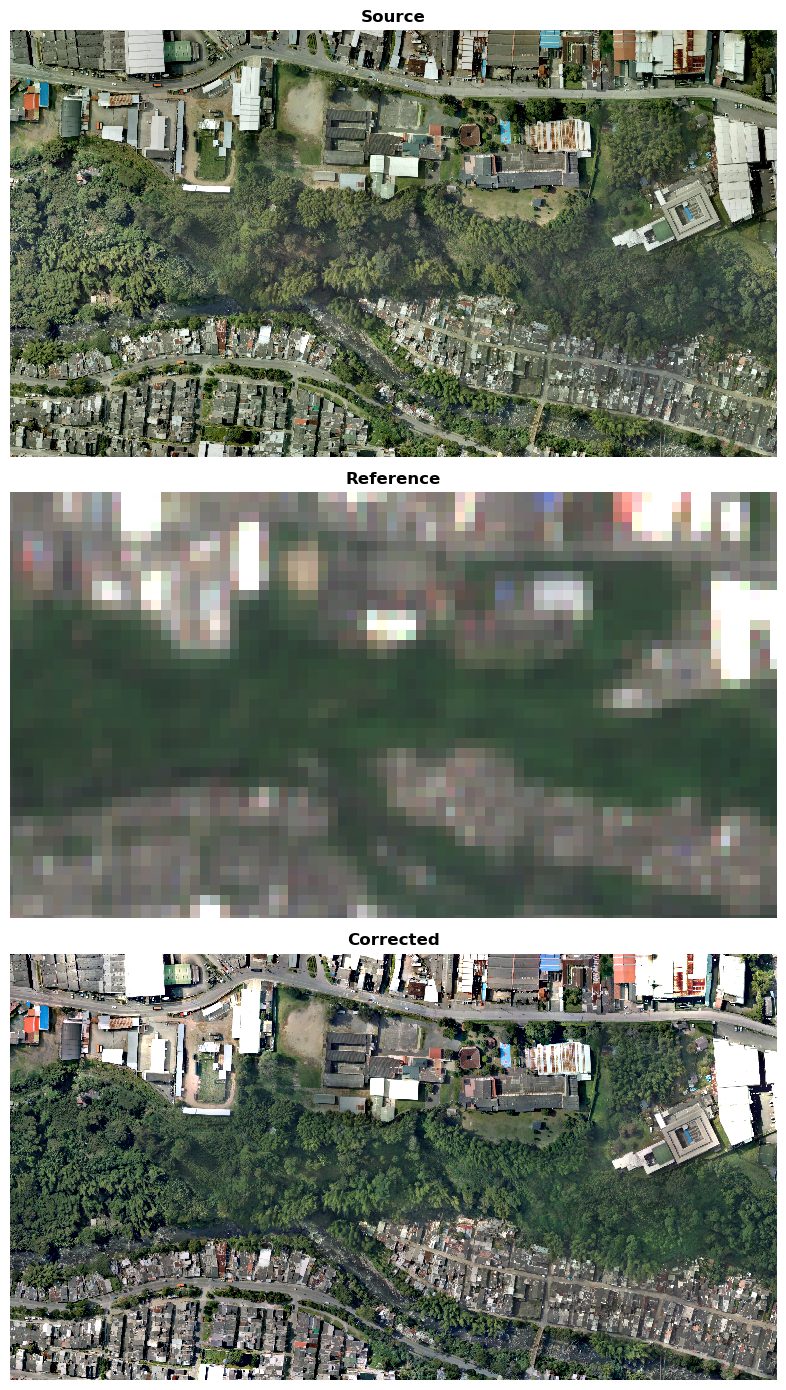

In [46]:
from rasterio.vrt import WarpedVRT
from rasterio.enums import Resampling
# VRT mosaic of the source files

fig, axes = pyplot.subplots(
    3, 1, sharex=True, sharey=True, tight_layout=True, figsize=(8, 14), 
    dpi=100,
)

indexes = [1, 2, 3]
src_crs = None

for im_file, ds_fact, sc_off, ax, label in zip(
    [src_path, ref_path, corr_path],
    [4, 1, 4],
    [[255, 0], [3500, .2], [3500, .2]],
    axes,
    ['Source', 'Reference', 'Corrected'], 
):
    # read, scale and display the image
    with rio.open(im_file, 'r') as _ds:
        src_crs = src_crs or _ds.crs
        with WarpedVRT(_ds, crs=src_crs, resampling=Resampling.bilinear) as ds:
            ds_shape = tuple(np.round(np.array(ds.shape) / ds_fact).astype('int'))
            transform = ds.transform * rio.Affine.scale(ds_fact)

            array = ds.read(indexes=indexes, out_dtype='float32', out_shape=ds_shape)

            # change nodata value to nan
            mask = np.any((array == ds.nodata) | np.isnan(array), axis=(0))
            array[:, mask] = np.nan
            
            # 'normalise' image 2%-98% -> 0-1
            array = np.clip((array / sc_off[0]) - sc_off[1], 0, 1)
            # for bi in range(array.shape[0]):
            #     array[bi] -= np.nanpercentile(array[bi], 1)
            #     array[bi] /= np.nanpercentile(array[bi], 95)
            #     array[bi] = np.clip(array[bi], 0, 1)

    ax = show(array[0:3], transform=transform, interpolation='nearest', ax=ax)

    ax.set_title(label, fontweight='bold')
    ax.axis('off')

# fig.savefig('drone-src_ref_corr.jpg', dpi=150)

## Evaluation

Finaly, we compare the *source*, and *corrected* similarity with a second (Landsat-8) *reference*.  

In [24]:
# URL of the Landsat-8 reference
cmp_ref_path = Path('LANDSAT-LC08-C02-T1_L2-LC08_009057_20220215_B432.tif')

print(RasterCompare.schema_table())

# loop over the source and corrected image files
for im_path, im_label in zip(
    [src_path, corr_path],
    ['Source', 'Corrected'],
):
    with RasterCompare(
        im_path, cmp_ref_path,
    ) as compare:
        # print a table of comparison statistics (the typical way of using 
        # RasterCompare)
        print(f'{im_label}:')
        stats_dict = compare.process()
        print(f'{im_label} comparison:\n\n' + compare.stats_table(stats_dict))

    # equivalent homonim command line:
    # !homonim compare {im_path} {cmp_ref_path}

Source and reference image will be re-projected to the same CRS: ES_WMM3_2022_02_08_Pereira_RGB.tif and LANDSAT-LC08-C02-T1_L2-LC08_009057_20220215_B432.tif
Assuming standard RGB center wavelengths (.65, .56 & .48 um) for ES_WMM3_2022_02_08_Pereira_RGB.tif.


ABBREV   DESCRIPTION
-------- -----------------------------------------
r²       Pearson's correlation coefficient squared
RMSE     Root Mean Square Error
rRMSE    Relative RMSE (RMSE/mean(ref))
N        Number of pixels
Source:


  0%|                                                                                                         …

Source and reference image will be re-projected to the same CRS: ES_WMM3_2022_02_08_Pereira_RGB_FUSE_cREF_mGAIN-BLK-OFFSET_k3_3.tif and LANDSAT-LC08-C02-T1_L2-LC08_009057_20220215_B432.tif


Source comparison:

  Band    r²      RMSE   rRMSE   N
------ ----- --------- ------- ---
 SR_B4 0.461 10694.846   1.013 405
 SR_B3 0.383 10729.988   1.007 405
 SR_B2 0.462  9475.038   1.010 405
  Mean 0.435 10299.958   1.010 405
Corrected:


  0%|                                                                                                         …

Corrected comparison:

  Band    r²     RMSE   rRMSE   N
------ ----- -------- ------- ---
 SR_B4 0.909 8596.610   0.814 405
 SR_B3 0.906 8574.500   0.804 405
 SR_B2 0.867 7435.318   0.793 405
  Mean 0.894 8202.142   0.804 405


Now the scatter plots.

Source and reference image will be re-projected to the same CRS: ES_WMM3_2022_02_08_Pereira_RGB.tif and LANDSAT-LC08-C02-T1_L2-LC08_009057_20220215_B432.tif
Assuming standard RGB center wavelengths (.65, .56 & .48 um) for ES_WMM3_2022_02_08_Pereira_RGB.tif.
Source and reference image will be re-projected to the same CRS: ES_WMM3_2022_02_08_Pereira_RGB_FUSE_cREF_mGAIN-BLK-OFFSET_k3_3.tif and LANDSAT-LC08-C02-T1_L2-LC08_009057_20220215_B432.tif


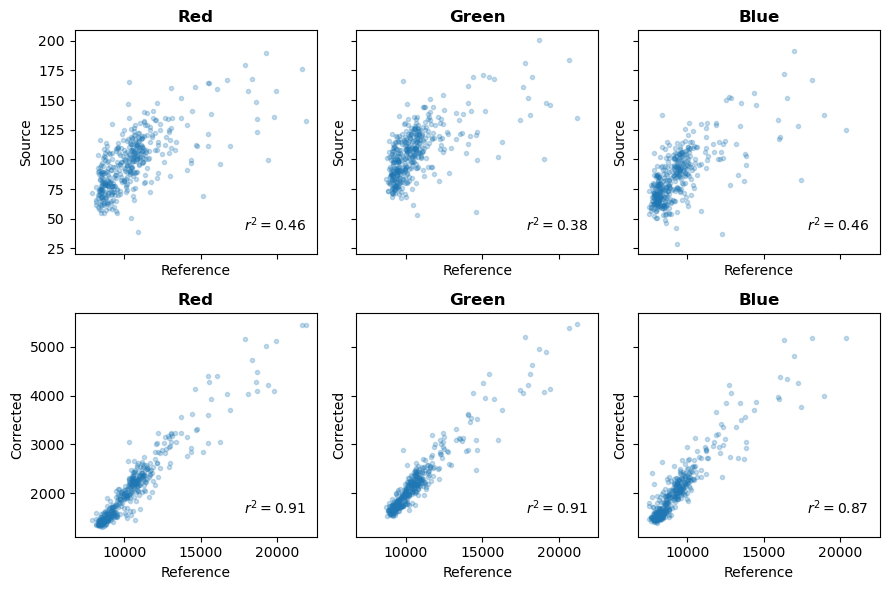

In [47]:
fig, axes = pyplot.subplots(
    2, 3, sharex='all', sharey='row', tight_layout=True, figsize=(9, 6), dpi=100
)

# loop over the source and corrected image files and corresponding axes etc
for im_i, im_path, axis, im_label in zip(
    range(2),
    [src_path, corr_path],
    axes,
    ['Source', 'Corrected'],
):
    with RasterCompare(im_path, cmp_ref_path) as compare:
        # produce per-band scatter plots of source/corrected - reference 
        # surface reflectance 
        # (note that in RasterCompare.block_pairs a 'block' takes the size of a 
        # band by default)
        for band_i, block_pair, band_label in zip(
            range(3),
            compare.block_pairs(),
            ['Red', 'Green', 'Blue']
        ):
            # read source/corrected - reference band pair, and reproject the 
            # source/corrected band to the reference CRS and pixel grid
            src_ra, ref_ra = compare.read(block_pair)
            src_ra = src_ra.reproject(
                **ref_ra.proj_profile, resampling='average'
            )

            # vectors of valid pixels in the source/corrected and reference bands
            mask = src_ra.mask & ref_ra.mask  # mask of valid pixels
            src_v, ref_v = src_ra.array[mask], ref_ra.array[mask]
            r2 = np.corrcoef(src_v, ref_v)[0, 1] ** 2 

            # create scatter plot
            ax = axes[im_i, band_i]
            ax.plot(ref_v, src_v, '.', alpha=0.25)
            ax.set_xlabel('Reference')
            ax.set_ylabel(im_label)
            ax.set_title(band_label, fontweight='bold')
            ylim = np.array(ax.get_ylim())
            ypos = 0.1*np.diff(ylim) + ylim[0]
            # ax.text(18000, ypos, f'$r^2={r2:.2f}$', fontweight='bold')
            ax.text(.7, .1, f'$r^2={r2:.2f}$', transform=ax.transAxes)

# fig.savefig('../case_studies/basic_correction-eval.png', dpi=100)
fig.savefig('drone-eval.png', dpi=100)